In [1]:
!echo "Last updated: `date`"

Last updated: Thu Aug  6 08:01:43 PDT 2020


# 1-dimensional Process Convolution ([Higdon 2002][1]) Example

## Model

$$
\begin{eqnarray}
y_n \mid f_n, \sigma &\sim& \text{Normal}(f_n, \sigma), \text{ for } n=1,\dots, N \\
\mathbf{f} &:=& \mathbf{K}_{\rho} \cdot \mathbf z \\
K_{n,m} &:=& \exp(-(x_n - w_m)^2 / \rho^2) \\
z_m &\sim& \text{Normal}(0, 1), \text{ for } m=1,\dots,M \\
\rho &\sim& \text{LogNormal}(0, 1) \\
\sigma &\sim& \text{LogNormal}(0, 1) \\
\end{eqnarray}
$$
where $w_m$ are knot points, and $M \ll N$. 

***

**References**

1. Higdon, Dave. "Space and space-time modeling using process convolutions." Quantitative methods for current environmental issues. Springer, London, 2002. 37-56.

[1]: https://link.springer.com/content/pdf/10.1007%2F978-1-4471-0657-9_2.pdf

In [2]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import norm
from tqdm import trange

# For reproducibility.
np.random.seed(1)

In [3]:
def make_gp_predict(x, w, n_new=1000, eps=0):
    n_grid = int(np.floor(np.sqrt(n_new)))
    x_new = np.linspace(x.min() - eps, x.max() + eps, n_new)
    D = distance_matrix(x_new.reshape(-1, 1), w.reshape(-1, 1))
    
    # Prediction (at new locations) is very simple.
    def gp_predict(z, rho):
        K = np.exp(-np.power(D/rho, 2))
        return K.dot(z)
    
    return gp_predict, x_new

In [4]:
# True function.
def f(x):
    return np.sin(3 * x) * np.sin(x) * (-1)**(x > 0) * 2

In [5]:
model_code = """
data {
  int<lower=0> N;
  int<lower=0> M;
  vector[N] y;
  vector[N] x;
  vector[M] w;
  real m_rho;
  real<lower=0> s_rho;
  real m_sigma;
  real<lower=0> s_sigma;
}

transformed data {
  matrix[N, M] D;  // Distance matrix.

  // Create distance matrix.
  for (n in 1:N) for (m in 1:M) {
    D[n, m] = abs(x[n] - w[m]);
  }
}

parameters {
  vector[M] z;  // White noise process.
  real<lower=0> rho;  // Range parameter in covariance.
  real<lower=0> sigma;  // model noise.
}

model {
  matrix[N, M] K;  // Kernel matrix.

  // Priors.
  rho ~ lognormal(m_rho, s_rho);
  sigma ~ lognormal(m_sigma, s_sigma);
  z ~ normal(0, 1);

  // Populate kernel matrix.
  for (n in 1:N) for (m in 1:M) {
    K[n, m] = exp(-(D[n, m]/rho)^2);
  }

  // Likelihood. (Can be chosen according to application.)
  y ~ normal(K * z, sigma);
}
"""

In [6]:
# Compile model. This takes about a minute.
%time sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7c51efede7ad88554d2cf72674a71e89 NOW.


CPU times: user 844 ms, sys: 48.9 ms, total: 893 ms
Wall time: 49 s


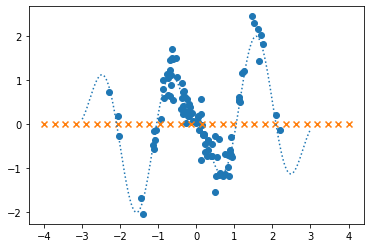

In [7]:
np.random.seed(1)
N = 100
x = np.sort(np.random.randn(N))
y = f(x) + np.random.randn(N) * 0.3
M = 30
w = np.linspace(-4, 4, M)
xgrid = np.linspace(-3, 3, 1000)

plt.scatter(x, y);
plt.scatter(w, np.zeros(M), marker='x')
plt.plot(xgrid, f(xgrid), ls=":");

In [16]:
data = dict(N=N, M=M, w=w, y=y, x=x,
            m_rho=0, s_rho=1, m_sigma=0, s_sigma=1)

In [15]:
%%time
# Fit via HMC
hmc_fit = sm.sampling(data=data, iter=2000, chains=1, warmup=1000, thin=1,
                      seed=3, algorithm='HMC', control=dict(stepsize=0.1, int_time=1))

CPU times: user 5.05 s, sys: 10.5 ms, total: 5.06 s
Wall time: 5.03 s


In [11]:
rho = hmc_fit['rho']
sigma = hmc_fit['sigma']
z = hmc_fit['z']
nsamples = sigma.shape[0]

In [12]:
# Get posterior function and predictive summaries.
gp_predict, x_new = make_gp_predict(x, w, 1000, eps=0.8)
fpreds = np.stack([gp_predict(z=z[i], rho=rho[i]) for i in trange(nsamples)], axis=-1)
preds = np.random.normal(fpreds, sigma[None, :])

100%|██████████| 1000/1000 [00:01<00:00, 727.09it/s]


**NOTE:** Extrapolation beyond the knots is not possible.

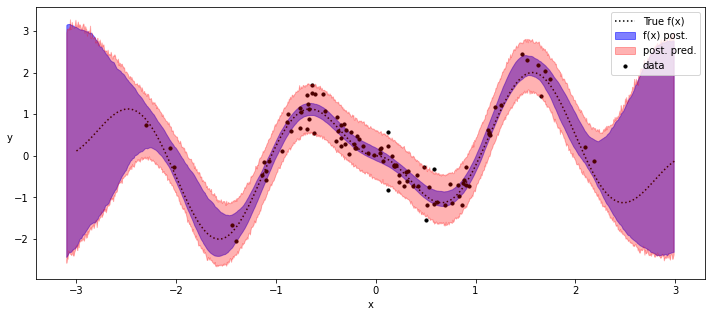

In [13]:
# Posterior predictive.
preds_mean = preds.mean(1)
preds_upper = np.percentile(preds, 2.5, axis=1)
preds_lower = np.percentile(preds, 97.5, axis=1)

# Function posterior.
fpreds_mean = fpreds.mean(1)
fpreds_upper = np.percentile(fpreds, 2.5, axis=1)
fpreds_lower = np.percentile(fpreds, 97.5, axis=1)

plt.figure(figsize=(12, 5))

# Plot function posterior.
plt.fill_between(x_new, fpreds_upper, fpreds_lower, color='blue',
                 alpha=0.5, label='f(x) post.')

# Plot posterior predictive.
plt.fill_between(x_new, preds_upper, preds_lower, color='red',
                 alpha=0.3, zorder=3, label='post. pred.')

# Plot data.
plt.scatter(x, y, c='black', s=10, label='data')

# Plot true function.
plt.plot(xgrid, f(xgrid), color='black', ls=":", label='True f(x)');

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend();

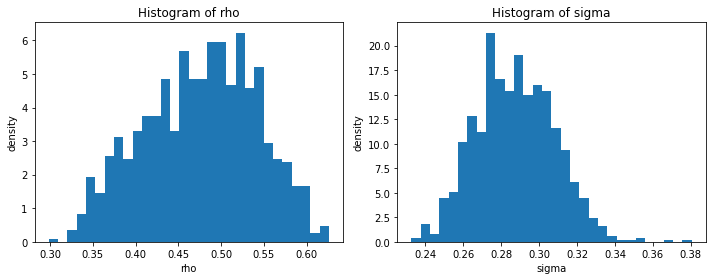

In [14]:
def plot_param(param, name):
    plt.hist(param, density=True, bins=30);
    plt.xlabel(name);
    plt.ylabel('density');
    plt.title('Histogram of {}'.format(name))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plot_param(rho, 'rho')

plt.subplot(1, 2, 2)
plot_param(sigma, 'sigma')

plt.tight_layout()